#Create the environment

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
%cd /content/drive/My Drive/ESoWC

/content/drive/My Drive/ESoWC


In [26]:
import pandas as pd
import xarray as xr
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

from sklearn.feature_selection import VarianceThreshold

from sklearn.decomposition import PCA

#Upload the dataset

In [16]:
dataset = xr.open_dataset('Data/05_2019_weather_and_CO.nc')
dataset

<xarray.Dataset>
Dimensions:         (latitude: 33, longitude: 33, time: 742)
Coordinates:
  * time            (time) datetime64[ns] 2019-05-01 ... 2019-05-31T21:00:00
  * latitude        (latitude) float64 43.0 43.25 43.5 43.75 ... 50.5 50.75 51.0
  * longitude       (longitude) float64 4.0 4.25 4.5 4.75 ... 11.5 11.75 12.0
Data variables: (12/15)
    EMISSIONS_2019  (time, latitude, longitude) float64 ...
    u10             (time, latitude, longitude) float64 ...
    v10             (time, latitude, longitude) float64 ...
    hcc             (time, latitude, longitude) float64 ...
    lcc             (time, latitude, longitude) float64 ...
    tcc             (time, latitude, longitude) float64 ...
    ...              ...
    tmp             (time, latitude, longitude) float64 ...
    sp_hum          (time, latitude, longitude) float64 ...
    rel_hum         (time, latitude, longitude) float64 ...
    tcwv            (time, latitude, longitude) float64 ...
    tcw             (time, latitude, longitude) float64 ...
    tot_wind        (time, latitude, longitude) float64 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-08-11 22:54:00

In [17]:
df = dataset.to_dataframe()
df = df.dropna()
df = df.reset_index()
df.head()

,latitude,longitude,time,EMISSIONS_2019,u10,v10,hcc,lcc,tcc,cvl,cvh,sp,tmp,sp_hum,rel_hum,tcwv,tcw,tot_wind
0,43.0,4.0,2019-05-01 01:00:00,1.605808e-13,2.960762,-5.035299,0.0,0.045595,0.046689,0.0,2.980232e-08,101555.247396,263.693481,0.000004,0.000227,14.677999,14.682165,5.841263
1,43.0,4.0,2019-05-01 02:00:00,1.405082e-13,3.289431,-4.350558,0.0,0.048083,0.050270,0.0,2.980232e-08,101520.182292,263.244812,0.000004,0.000235,14.246251,14.249586,5.454147
2,43.0,4.0,2019-05-01 03:00:00,1.354900e-13,3.618101,-3.665817,0.0,0.050570,0.053851,0.0,2.980232e-08,101485.117188,262.796143,0.000004,0.000243,13.814503,13.817007,5.150618
3,43.0,4.0,2019-05-01 04:00:00,1.354900e-13,3.346790,-3.465523,0.0,0.035199,0.038485,0.0,2.980232e-08,101505.005208,262.032552,0.000004,0.000264,13.644949,13.647179,4.817765
4,43.0,4.0,2019-05-01 05:00:00,1.455263e-13,3.075480,-3.265230,0.0,0.019827,0.023118,0.0,2.980232e-08,101524.893229,261.268962,0.000004,0.000284,13.475395,13.477350,4.485566


In [18]:
all_name = df.columns.difference(['latitude','longitude','time'])
x_name = all_name.difference(["EMISSIONS_2019"])
y_name = ["EMISSIONS_2019"]

seed = 1111

In [19]:
scaler = MinMaxScaler()

df_norm =  pd.DataFrame(scaler.fit_transform(df[all_name]), columns=df[all_name].columns)
df_norm.head()

,EMISSIONS_2019,cvh,cvl,hcc,lcc,rel_hum,sp,sp_hum,tcc,tcw,tcwv,tmp,tot_wind,u10,v10
0,0.000015,0.0,0.0,2.980215e-08,0.045595,0.63961,0.923303,0.000000,0.046689,0.353796,0.360875,0.188289,0.301288,0.515923,0.430374
1,0.000013,0.0,0.0,2.980215e-08,0.048083,0.67372,0.921905,0.009950,0.050270,0.341166,0.348015,0.162800,0.281312,0.530493,0.456249
2,0.000013,0.0,0.0,2.980215e-08,0.050570,0.70783,0.920507,0.019900,0.053851,0.328536,0.335154,0.137311,0.265650,0.545064,0.482124
3,0.000013,0.0,0.0,2.980215e-08,0.035199,0.79351,0.921300,0.019292,0.038484,0.323577,0.330104,0.093932,0.248474,0.533036,0.489692
4,0.000014,0.0,0.0,2.980215e-08,0.019827,0.87919,0.922093,0.018684,0.023118,0.318619,0.325053,0.050553,0.231332,0.521008,0.497261


##Baseline Performance

In [20]:
kfolds = KFold(10,shuffle=True,random_state=1234)

model = linear_model.LinearRegression()
scores = cross_val_score(model, df_norm[x_name], df_norm[y_name], cv=kfolds)

print("R2 Mean %.3f StdDev %.3f"%(scores.mean(),scores.std()))

R2 Mean 0.047 StdDev 0.003


#Reduced Variance Feature Selection

In [21]:
feature_selection_variance_model = VarianceThreshold(threshold=(.95 * (1 - .95)))
X_selected_features_variance = feature_selection_variance_model.fit_transform(df_norm[x_name])

mask = feature_selection_variance_model.get_support() #list of booleans
print("Reduced data set shape = ", X_selected_features_variance.shape)
print("     Selected features = ", df_norm[x_name].columns[mask])
print("      Deleted Features = ", df_norm[x_name].columns[~mask])

Reduced data set shape =  (784080, 5)
     Selected features =  Index(['cvh', 'cvl', 'hcc', 'lcc', 'tcc'], dtype='object')
      Deleted Features =  Index(['rel_hum', 'sp', 'sp_hum', 'tcw', 'tcwv', 'tmp', 'tot_wind', 'u10',
       'v10'],
      dtype='object')


In [22]:
variance_model = LinearRegression()
variance_scores = cross_val_score(variance_model, df_norm[x_name].loc[:,mask], y, cv=kfolds)
print("Variance Model R2 Mean %.3f StdDev %.3f"%(variance_scores.mean(),variance_scores.std()))

Variance Model R2 Mean 0.019 StdDev 0.002


##Feature selection with random forest

In [23]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0) #Random_state=0 is error because now everytime we run the script we get a different result
forest.fit(df_norm[x_name], df_norm[y_name])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=0, verbose=0, warm_start=False)

Feature ranking:
 1. feature  1     cvl (0.229)
 2. feature  0     cvh (0.213)
 3. feature  5      sp (0.149)
 4. feature  6  sp_hum (0.055)
 5. feature 13     v10 (0.046)
 6. feature 12     u10 (0.040)
 7. feature  9    tcwv (0.039)
 8. feature  8     tcw (0.038)
 9. feature 11 tot_wind (0.034)
10. feature  3     lcc (0.033)
11. feature  2     hcc (0.032)
12. feature 10     tmp (0.032)
13. feature  7     tcc (0.029)
14. feature  4 rel_hum (0.029)


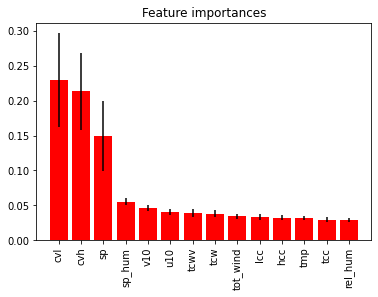

In [24]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_norm[x_name].shape[1]):
    print("%2d. feature %2d %7s (%.3f)" % (f + 1, indices[f], df_norm[x_name].columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_norm[x_name].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_norm[x_name].shape[1]), df_norm[x_name].columns[indices],rotation=90)
plt.xlim([-1, df_norm[x_name].shape[1]])
plt.show()

#Principal Component Analysis

In [27]:
full_pca_model = PCA()
full_fitted_model = full_pca_model.fit(df_norm[x_name])
full_fitted_model.explained_variance_ratio_

array([3.92690078e-01, 1.50434413e-01, 1.30000295e-01, 9.31962253e-02,
       7.93044072e-02, 3.78075522e-02, 3.38259391e-02, 2.97803836e-02,
       2.57368625e-02, 1.15075952e-02, 1.05776210e-02, 4.38206741e-03,
       7.19413519e-04, 3.71476944e-05])

In [28]:
x_max=len(x_name)
x_max

14

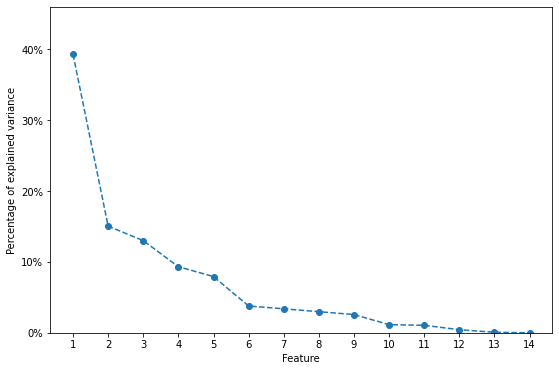

In [33]:
plt.figure(figsize=(9, 6))
plt.plot(full_fitted_model.explained_variance_ratio_, '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.xlabel("Feature");
plt.ylabel("Percentage of explained variance");
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.0,0.46,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.0,0.46,.1)]);
plt.ylim([0.0,0.46]);

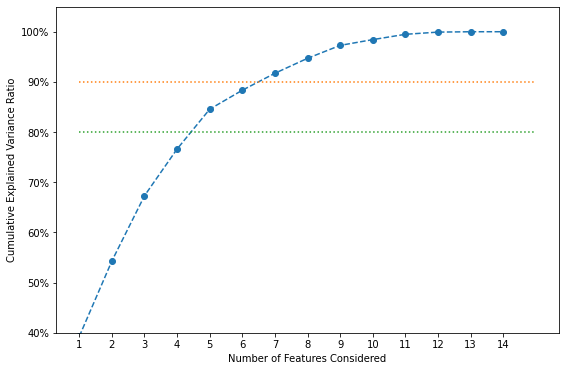

In [34]:
plt.figure(figsize=(9, 6))
plt.plot(full_fitted_model.explained_variance_ratio_.cumsum(), '--o');
plt.xticks(np.arange(0,x_max,1),labels=np.arange(1,x_max+1,1));
plt.yticks(np.arange(0.4,1.1,.1),labels=["%.0f%%"%(x*100) for x in np.arange(0.4,1.1,.1)]);
plt.ylim([0.4,1.05]);
plt.plot([0,x_max],[.9,.9],':');
plt.plot([0,x_max],[.8,.8],':');
plt.xlabel("Number of Features Considered");
plt.ylabel("Cumulative Explained Variance Ratio");

In [35]:
feature_selection_pca_model = PCA(n_components=10)
fitted_model = feature_selection_pca_model.fit(df_norm[x_name])

X_selected_features_pca = fitted_model.transform(df_norm[x_name])
print("    Explained Variance = %.3f" % fitted_model.explained_variance_ratio_.cumsum()[-1])
print("Reduced data set shape =",X_selected_features_pca.shape)

    Explained Variance = 0.984
Reduced data set shape = (784080, 10)


In [36]:
pca_model = linear_model.LinearRegression()
pca_scores = cross_val_score(pca_model, X_selected_features_pca, df_norm[y_name], cv=kfolds)
pca_scores.mean()
print("PCA Model R2 Mean %.3f StdDev %.3f"%(pca_scores.mean(),pca_scores.std()))

PCA Model R2 Mean 0.043 StdDev 0.003
